In [1]:
import pandas as pd
import requests
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import haversine as hs
import matplotlib.pyplot as plt

In [2]:
df_original = pd.read_csv('folder/data.csv')

In [3]:
df = df_original

In [4]:
#1 dropping End-Time & Start Date
df=df.drop(['START_DATE'], axis=1)

#2 renaming columns to match structure of requests.csv
df=df.rename(columns={"START_TIME":"treq","START_LONGITUDE":"origin_x","START_LATITUDE":"origin_y","END_LONGITUDE":"destination_x","END_LATITUDE":"destination_y",})

In [5]:
#3 drop out of bound trips
minLong = 11.8735
minLat = 57.6265
maxLong = 12.0427
maxLat = 57.7712

len1=len(df)
len1
df.drop(df.loc[df['origin_x']<minLong].index, inplace=True)
df.drop(df.loc[df['origin_y']<minLat].index, inplace=True)
df.drop(df.loc[df['destination_x']<minLong].index, inplace=True)
df.drop(df.loc[df['destination_y']<minLat].index, inplace=True)
df.drop(df.loc[df['origin_x']>maxLong].index, inplace=True)
df.drop(df.loc[df['origin_y']>maxLat].index, inplace=True)
df.drop(df.loc[df['destination_x']>maxLong].index, inplace=True)
df.drop(df.loc[df['destination_y']>maxLat].index, inplace=True)
len2=len(df)

print("Rows removed:", len1-len2)


Rows removed: 258


In [38]:
## 4 analysing distance between two points (to determine minimum distance to clean out)
#n.b. the haversine distance is only the flying distance between the origin and destination coordinates and does not reflect how much distance a trip actually covered. The scope of analysing distances is to remove absurdely short trips. VOI already mentioned that trips <100m were removed. 
#to aid in assuring clean data, trip duration is also being considered and compared to the 'flying distance'. Trips that have both a short (TBD) distance and a short duration will be removed.  

df['loc1']= list(zip(df.origin_x, df.origin_y))
df['loc2']= list(zip(df.destination_x, df.destination_y))
f = lambda loc1, loc2 : hs.haversine(loc1, loc2, unit='m')
df['hav_dist_m'] = df.apply(lambda x: f(x.loc1, x.loc2), axis=1)
df=df.drop(['loc1','loc2'], axis=1)

In [40]:
#5. formatting treq to datetime, keeping seconds seconds, and incrementing to UTC+1 since we assume that GTFS data is saved in Gothenburg's local time 
df['treq'] = pd.to_datetime(df['treq'], format='%Y-%m-%d %H:%M:%S')
df['treq'] = pd.to_datetime(df['treq'].dt.strftime('%Y-%m-%d %H:%M:%S'))
df['treq']=df['treq'] + timedelta(hours=1) #adding 1 hour to bring from UTC 0 to UTC+1 (Gothenburg local time)

df['END_TIME'] = pd.to_datetime(df['END_TIME'], format='%Y-%m-%d %H:%M:%S')
df['END_TIME'] = pd.to_datetime(df['END_TIME'].dt.strftime('%Y-%m-%d %H:%M:%S'))
df['END_TIME']=df['END_TIME'] + timedelta(hours=1) #adding 1 hour to bring from UTC 0 to UTC+1 (Gothenburg local time)


df['duration_in_m']=df['END_TIME']-df['treq']
df['duration_in_m']=(df.duration_in_m.dt.total_seconds() / 60)


### Plotting graphs

1. Distribution of distances
2. Distribution of times

<AxesSubplot:ylabel='Frequency'>

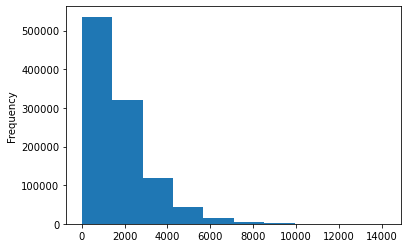

In [41]:
df['hav_dist_m'].plot(kind='hist')

In [ ]:
df = df.head(3000)

242277

<AxesSubplot:>

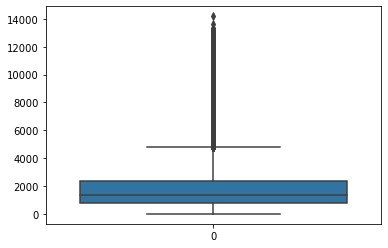

In [48]:
sns.boxplot(data=df['hav_dist_m'])

<AxesSubplot:>

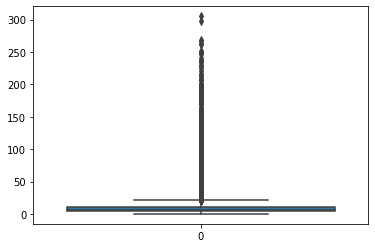

In [50]:
sns.boxplot(data=df['duration_in_m']) #there are some long durations, but they may likely be by users who neglected to end a trip properly. They needn't be removed (IMO) since the main scope of this projec is to assess (topologically) whether PT could have replaced a trip

<AxesSubplot:ylabel='Frequency'>

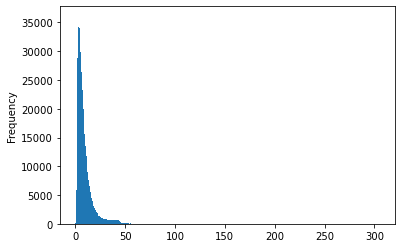

In [52]:
df['duration_in_m'].plot(kind='hist', bins=1000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


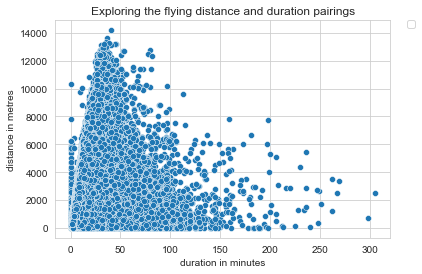

In [54]:
##scatter plot of distance and time

sns.set_style(style='whitegrid')

sns.scatterplot(
    data=df, 
    x='duration_in_m', 
    y='hav_dist_m',
    palette='Paired_r'
    )

plt.title('Exploring the flying distance and duration pairings')
plt.xlabel('duration in minutes')
plt.ylabel('distance in metres')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

In [79]:
## how many trips where duration = 0?


duration_0=len(df[df['duration_in_m']<1])
distance_0=len(df[df['hav_dist_m']<100])
dur_and_dist_0=len(df[(df['duration_in_m']<1) & (df['hav_dist_m']<100)])

print(duration_0, distance_0, dur_and_dist_0)

2836 26073 20


### else

In [113]:
df['month']=df['treq'].dt.month
df.sort_values(by='month', ascending=True, inplace=True)
df.shape[0]

1040373

In [110]:
#1. Distribution of trips by month

df_tripCount = pd.DataFrame(df['TRIP_ID'].groupby(df.treq.dt.month).agg('count'))

df_tripCount.to_csv('months.csv')

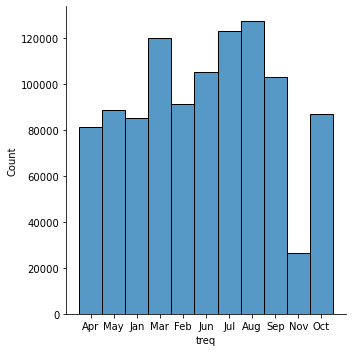

In [65]:

chart = sns.displot(tripCount, x= month.dt.strftime("%b"), bins=10, order=table.sort_values())
chart.order

In [8]:
#2. Distribution of trip duration 

In [ ]:
#3. Distrubtion of trip time